In [54]:
# %load ../python_script/feature_extraction
import cv2
import numpy as np
from skimage import data
from skimage.feature import hog
from skimage import data, exposure
from skimage.color import label2rgb
from skimage.transform import rotate
from skimage.feature import local_binary_pattern


def histogram_oriented_gradients(image):
    # Example usage on a single image
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(1, 1),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)

    # Visualize the HOG image
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image_rescaled
  
def scale_invariant_feature_transform(image):
    
    # Convert the image depth to CV_8U
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    #reading image
    gray1 = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)
    
    #keypoints
    #keypoints``
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(gray1, None)

    img_1 = cv2.drawKeypoints(gray1,keypoints_1,image)
    return img_1
    
def local_binary_patterns(image):
    
    # settings for LBP
    radius = 3
    n_points = 8 * radius
    
    # Convert the image depth to CV_8U
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Convert the array to grayscale and reshape it to (height, width)
    gray1 = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray1, n_points, radius, method = "uniform")

    return lbp

In [55]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [56]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=70,color=True)

# lfw_dataset is a disctionary
print("number of keys in the lfw_dataset is as ", lfw_dataset.keys())

number of keys in the lfw_dataset is as  dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])


In [57]:
image_rescaled = {}
image_rescaled["original_image"] = np.array(lfw_dataset.images)

### 1. Preparing the scale_invariant_feature_transform data

In [58]:
### passing the single image to the function to check the result
flattend_arr = []
sift_image = []
for image in lfw_dataset.images:
    arr_2d = scale_invariant_feature_transform(image)
    sift_image.append(arr_2d)
    flattend_arr.append(arr_2d.flatten())

image_rescaled["sift_data"] = np.array(flattend_arr)
image_rescaled["sift_image"] = np.array(sift_image)

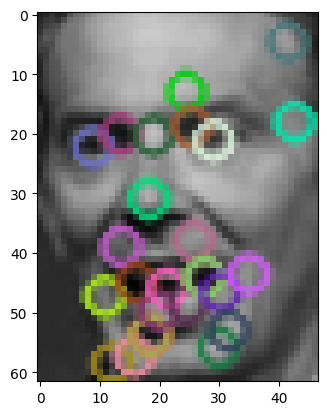

In [59]:
plt.imshow(image_rescaled["sift_image"][1])

In [60]:
image_rescaled.keys()

dict_keys(['original_image', 'sift_data', 'sift_image'])

### 2. Preparing the histogram_oriented_gradients of sift_data

In [61]:
### passing the single image to the function to check the result
flattend_arr = []
hog_sift_image = []
for image in image_rescaled["sift_image"]:
    arr_2d = histogram_oriented_gradients(image)
    hog_sift_image.append(arr_2d)
    flattend_arr.append(arr_2d.flatten())
    
image_rescaled["hog_sift_data"] = np.array(flattend_arr)
image_rescaled["hog_sift_image"] = np.array(hog_sift_image)

/tmp/ipykernel_21201/3443745518.py:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(1, 1),


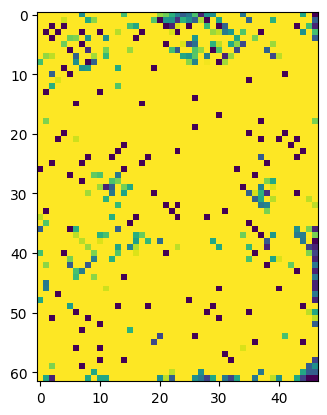

In [62]:
plt.imshow(image_rescaled["hog_sift_image"][2])

### 3. Preparing the histogram_oriented_gradients of data

/tmp/ipykernel_21201/3443745518.py:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(1, 1),


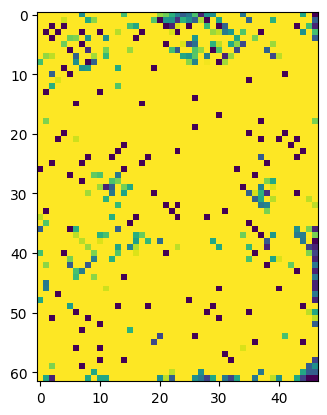

In [63]:
### passing the single image to the function to check the result
flattend_arr = []
hog_image = []
for image in image_rescaled["sift_image"]:
    arr_2d = histogram_oriented_gradients(image)
    hog_image.append(arr_2d)
    flattend_arr.append(arr_2d.flatten())
    
image_rescaled["hog_data"] = np.array(flattend_arr)
image_rescaled["hog_image"] = np.array(hog_sift_image)

plt.imshow(image_rescaled["hog_image"][2])

### 4. using sift_hog on xg boost

In [68]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [69]:
image_rescaled.keys()

dict_keys(['original_image', 'sift_data', 'sift_image', 'hog_sift_data', 'hog_sift_image', 'hog_data', 'hog_image'])

In [70]:
X = image_rescaled['hog_sift_data']
y = lfw_dataset['target']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

In [74]:
# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.5387596899224806

(array([[252, 252, 252, ...,  74,  74,  74],
        [ 32,  32,  32, ..., 148, 148, 148],
        [ 98,  98,  98, ..., 210, 210, 210],
        ...,
        [ 81,  81,  81, ...,  30,  30,  30],
        [ 50,  50,  50, ..., 167, 167, 167],
        [ 31,  31,  31, ...,  81,  81,  81]], dtype=uint8),
 array([[0.3, 1. , 1. , ..., 0.1, 0. , 0. ],
        [1. , 1. , 1. , ..., 1. , 0. , 0. ],
        [1. , 1. , 1. , ..., 0.2, 0. , 0. ],
        ...,
        [1. , 1. , 1. , ..., 1. , 0. , 0. ],
        [1. , 1. , 1. , ..., 1. , 0. , 0. ],
        [0.8, 1. , 1. , ..., 1. , 0. , 0. ]]))

### 5. Combine HOG and SIFT features

In [78]:
# Combine HOG and SIFT features
X_combined = np.hstack((image_rescaled["sift_data"], image_rescaled["hog_data"]))

In [79]:
X_combined

array([[2.52e+02, 2.52e+02, 2.52e+02, ..., 1.00e-01, 0.00e+00, 0.00e+00],
       [3.20e+01, 3.20e+01, 3.20e+01, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [9.80e+01, 9.80e+01, 9.80e+01, ..., 2.00e-01, 0.00e+00, 0.00e+00],
       ...,
       [8.10e+01, 8.10e+01, 8.10e+01, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [5.00e+01, 5.00e+01, 5.00e+01, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [3.10e+01, 3.10e+01, 3.10e+01, ..., 1.00e+00, 0.00e+00, 0.00e+00]])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [83]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.6937984496124031

---